## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [ ] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo

In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
from scipy import stats

from itertools import combinations

In [2]:
def outliers(df:pd.DataFrame,cols : list):
    index_outliers =  []
    for col in cols:
        s = df[col]
        Q1 = s.quantile(0.1)
        Q3 = s.quantile(0.9)
        lower_bound =  Q1
        upper_bound =  Q3 
        index_outliers.extend(s.index[(s < lower_bound) | (s > upper_bound)])
    return set(index_outliers)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined[bd_combined.IdeUsinaOutorga==27339]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [5]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask,"IdeUsinaOutorga"] = bd_combined.loc[mask,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
674,29710,NaT,2010-01-20,2013-07-10,2013-11-28,SC,2.5812,2008-11-10,2010-03-31,2009-03-10,...,None,2009-10-30,2013-01-15,NaT,2010-10-25,CGH,2,2.448,bdworgs,None
1972,33144,2017-12-01,2018-01-01,2017-09-21,2017-10-06,PI,29.4000,2017-03-15,2016-10-15,2017-10-01,...,2017-06-30,NaT,NaT,2017-04-01,2016-10-15,EOL,2,4.200,bdworgs,None
4555,40879,2020-11-15,2020-11-20,2020-11-21,2021-01-12,CE,25200.0000,2020-03-02,2019-10-29,2020-04-01,...,None,NaT,NaT,2019-06-01,2020-02-17,EOL,3,12600.000,skate,2019-07-02
5328,48643,2023-08-01,2023-09-02,NaT,NaT,BA,29934.0000,2022-04-25,NaT,NaT,...,None,NaT,NaT,2022-09-08,NaT,UFV,6,29934.000,skate,2020-11-17
5780,51448,2023-03-21,2023-04-01,NaT,NaT,PA,3780.0000,2022-05-17,NaT,NaT,...,None,NaT,NaT,2023-02-19,NaT,UTE,12,3780.000,skate,2021-11-09
3975,37620,2025-05-01,2025-06-01,NaT,NaT,PI,44400.0000,2024-01-01,NaT,NaT,...,None,NaT,NaT,2024-03-31,NaT,UFV,1,44400.000,skate,2022-04-19
885,30288,2011-11-23,NaT,2012-08-24,2013-02-01,BA,30.0000,2010-08-01,2011-12-08,2011-03-01,...,2012-05-10,NaT,NaT,NaT,NaT,EOL,1,30.000,bdworgs,None
1646,31644,2017-12-27,2018-01-01,2018-05-10,2018-06-16,CE,23.1000,2017-04-24,2016-11-15,2017-06-30,...,2017-10-16,NaT,NaT,2017-06-07,2017-04-07,EOL,7,14.700,bdworgs,None
1779,31832,2019-09-01,2019-10-30,2018-12-01,2019-02-06,BA,25.0000,2017-12-15,2018-04-24,2019-01-30,...,2018-08-20,NaT,NaT,2017-11-05,2018-05-14,EOL,10,25.000,bdworgs,None


In [6]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [7]:
bd_combined = bd_combined[bd_combined.DatUGInicioOpComerOutorgado.notna()
                            & bd_combined.DatLiberOpComerRealizado.notna()].copy(deep=True)

In [8]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [9]:
nomes_tempo_construcao = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
} 

tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao"]].copy(deep=True)
for nome,marco in nomes_tempo_construcao.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
5,42_2,UHE,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,561 days,NaT,NaT,NaT,15 days
7,161,PCH,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,697 days,419 days,NaT,45 days,1676 days


In [10]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso"]],2))
#combinacoes = list(combinations(["IO","CC","ME","MT","OT"],2))

for p_marco, s_marco in combinacoes:
    idx_loop =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())

    idx = idx_loop if is_first else (idx & idx_loop)
    is_first = False 

#idx_usinas = idx & (tempo_construcao_por_UG.IO_OC.notna())
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[idx].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,26 days,-380 days


In [11]:
tempo_construcao_por_UG[~idx]

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
96,27339,UTE,-8354 days,NaT,NaT,0 days,0 days
223,28462,UTE,-1560 days,NaT,NaT,71 days,180 days
292,28780,PCH,885 days,454 days,546 days,79 days,349 days
293,28780,PCH,885 days,454 days,546 days,79 days,318 days
448,29122,UTE,-202 days,NaT,NaT,31 days,-1101 days
...,...,...,...,...,...,...,...
4557,40879,EOL,533 days,340 days,121 days,144 days,145 days
4569,40884,EOL,207 days,293 days,141 days,27 days,16 days
4570,40884,EOL,221 days,307 days,155 days,41 days,30 days


In [12]:
idx_primeira_ug =  bd_combined[idx].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
493,29245,2008-01-01,2008-03-31,2009-06-20,2009-10-03,RS,17.87,2009-08-01,2007-12-02,2006-11-01,...,None,NaT,NaT,NaT,NaT,PCH,1,5.715,bdworgs,None
1877,32349,2017-09-12,2017-10-01,2017-11-21,2018-04-13,BA,27.50,2016-05-02,2017-04-01,2016-07-11,...,2017-09-15,NaT,NaT,2016-05-14,2017-12-12,EOL,5,12.500,bdworgs,None
2201,34717,2018-09-15,2018-11-01,2018-09-28,2018-11-14,BA,27.30,2018-01-13,2018-01-13,2018-03-01,...,2018-06-13,NaT,NaT,2018-01-30,2018-01-13,EOL,5,10.500,bdworgs,None
3442,35109,2020-01-01,2020-02-01,2020-07-02,2020-08-12,SP,20893.00,2017-02-01,2018-08-31,NaT,...,None,NaT,NaT,2017-10-01,2019-07-01,UTE,3,8953.000,skate,2016-10-05
712,29736_4,2013-02-28,2013-03-31,2014-07-10,2014-07-29,RO,3750.00,2010-09-01,2009-12-01,2010-10-01,...,None,2012-11-30,2012-10-19,NaT,NaT,UHE,1,75.000,bdworgs,None
3174,34107,2018-09-01,2018-11-01,2020-02-28,2020-03-10,SP,5000.00,2017-12-01,2019-03-10,NaT,...,None,NaT,NaT,2017-12-01,2019-11-10,UFV,40,5000.000,skate,2016-07-05
1979,33187,2018-09-01,2018-11-01,2018-04-07,2018-05-04,MG,31.00,2017-12-01,2017-10-31,NaT,...,None,NaT,NaT,2017-12-01,2017-09-30,UFV,31,30.000,bdworgs,None
124,27842,NaT,2003-10-30,2011-01-18,2011-02-03,MG,14.00,2001-08-10,2008-11-01,NaT,...,None,NaT,2010-12-11,NaT,NaT,PCH,2,14.000,bdworgs,None
2993,33430,2021-09-01,2021-09-21,2021-08-27,2021-11-04,RN,28400.00,2020-03-18,2020-06-15,2020-05-18,...,None,NaT,NaT,2020-04-05,2020-06-16,EOL,1,3550.000,skate,2019-09-03


In [13]:
# Atrasos por usinas são calculados com base UG com menor atraso.
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
#tempo_construcao_por_usina.set_index(keys = "IdeUsinaOutorga",inplace=True)
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,26 days,-380 days


In [19]:
def divide(a,b):
    mask = a.notna()
    if len(a[mask])>0:
        a[mask] = a[mask]/b
    else:
        pass
    return a

tipos_geracao = bd_combined.SigTipoGeracao.unique()
tempo_construcao_por_usina_norm = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
tempo_construca_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    tempo_construca_mean_dp[SigTipoGeracao] = {}
    for tempo in ["IO_OC","CC_OC","ME_OC","OT_OC","Atraso"]:
        tempo_construca_mean_dp[SigTipoGeracao][tempo] = {}
        mask = tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao
        m = tempo_construcao_por_usina.loc[mask,tempo].mean()
        s= tempo_construcao_por_usina.loc[mask,tempo].std()
        tempo_construca_mean_dp[SigTipoGeracao][tempo]["media"] = m.days/30
        tempo_construca_mean_dp[SigTipoGeracao][tempo]["dp"] = s.days/30
        tempo_construcao_por_usina_norm.loc[mask,tempo] = divide((tempo_construcao_por_usina.loc[mask,tempo] - m),s)   
tempo_construcao_por_usina_norm


,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,-0.510674,-1.267459,NaN,-0.671693,0.830213
1,12_1,UHE,-0.385251,-1.140075,NaN,-0.609173,-0.021921
2,19,UTE,-0.137639,NaT,NaN,-0.63144,2.862015
3,42_0,UHE,-0.528592,NaT,NaN,-0.640433,0.727525
4,42_1,UHE,-0.476468,NaT,NaN,-0.624803,-0.36782
...,...,...,...,...,...,...,...
5752,50872,UTE,-0.769889,NaN,-0.515903,-0.407591,-1.738998
5776,51444,UTE,-0.76858,NaN,-0.514677,-0.529109,-0.974306
5782,51450,UTE,-0.762035,NaN,-0.508543,-0.503526,-0.96716


In [20]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        #tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,CC_OC_media,ME_OC_media,OT_OC_media,Atraso_media
SigTipoGeracao,,,,,
UHE,1845 days 12:18:46.956521728,1621 days 03:27:45.671641792,1516 days 07:42:13.333333328,50 days 23:23:04.615384615,204 days 04:02:01.008403362
UTE,686 days 03:32:05.581395352,NaT,518 days 12:51:14.157303368,104 days 17:30:13.533834586,296 days 15:39:25.714285716
PCH,876 days 02:01:03.716814160,644 days 20:41:08.571428568,402 days 15:49:56.858638744,50 days 12:36:08.339768340,993 days 17:03:00.694980688
CGH,895 days 13:55:12,666 days 22:28:05.106382976,480 days 01:12:00,103 days 00:48:48.813559322,415 days 05:36:00
EOL,561 days 17:28:45.746799432,493 days 03:34:14.935622320,357 days 22:04:08.275862068,58 days 14:10:04.267425320,66 days 12:15:21.763869132
UFV,376 days 21:46:29.403973508,NaT,244 days 08:09:36,70 days 22:24:38.145695364,-5 days +20:20:39.735099338


In [21]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in nomes_tempo_construcao.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [22]:
marco_medio_usina

,IdeUsinaOutorga,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,
0,12_0,2002-02-09 11:41:13.043478272,2002-09-21 20:32:14.328358208,2003-01-04 16:17:46.666666672,2007-01-09 00:36:55.384615385
1,12_1,2003-08-13 11:41:13.043478272,2004-03-24 20:32:14.328358208,2004-07-07 16:17:46.666666672,2008-07-12 00:36:55.384615385
2,19,2000-02-14 20:27:54.418604648,NaT,2000-07-31 11:08:45.842696632,2001-09-18 06:29:46.466165414
3,42_0,1998-11-10 11:41:13.043478272,1999-06-22 20:32:14.328358208,1999-10-05 16:17:46.666666672,2003-10-10 00:36:55.384615385
4,42_1,2000-08-11 11:41:13.043478272,2001-03-23 20:32:14.328358208,2001-07-06 16:17:46.666666672,2005-07-11 00:36:55.384615385
...,...,...,...,...,...
5752,50872,2022-07-10 20:27:54.418604648,NaT,2022-12-25 11:08:45.842696632,2024-02-12 06:29:46.466165414
5776,51444,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414
5782,51450,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414


In [23]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in nomes_tempo_construcao.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [24]:
atraso_usina.sample(10)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
922,30320,EOL,733 days,104 days 17:28:45.746799432,127 days 03:34:14.935622320,357 days 22:04:08.275862068,767 days 14:10:04.267425320
4032,37719,UTE,475 days,556 days 03:32:05.581395352,NaT,388 days 12:51:14.157303368,504 days 17:30:13.533834586
1766,31816,EOL,-158 days,25 days 17:28:45.746799432,-17 days +03:34:14.935622320,NaT,-162 days +14:10:04.267425320
1089,30543,UTE,356 days,819 days 03:32:05.581395352,NaT,NaT,450 days 17:30:13.533834586
3953,37584,UFV,207 days,155 days 21:46:29.403973508,NaT,187 days 08:09:36,148 days 22:24:38.145695364
888,30292,EOL,637 days,105 days 17:28:45.746799432,98 days 03:34:14.935622320,119 days 22:04:08.275862068,667 days 14:10:04.267425320
3658,35800,PCH,818 days,981 days 02:01:03.716814160,1114 days 20:41:08.571428568,930 days 15:49:56.858638744,789 days 12:36:08.339768340
1465,31344,EOL,8 days,170 days 17:28:45.746799432,144 days 03:34:14.935622320,NaT,26 days 14:10:04.267425320
2108,33893,PCH,-108 days,208 days 02:01:03.716814160,51 days 20:41:08.571428568,24 days 15:49:56.858638744,-73 days +12:36:08.339768340


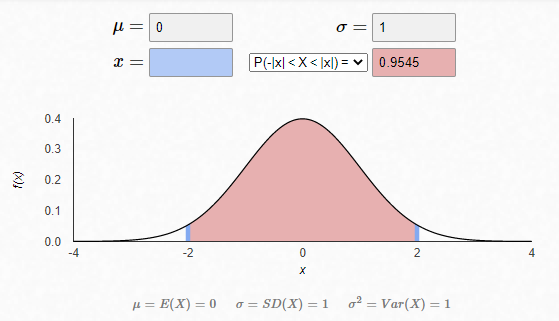

Não foi possível calcular: DatConcretagemRealizado_atraso para UTE
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,71.4%,74.1%,43.9%,99.9%
UTE,80.6%,-,79.2%,99.3%
PCH,96.1%,96.9%,98.6%,99.8%
CGH,71.3%,87.1%,92.2%,99.7%
EOL,88.8%,88.4%,91.7%,99.9%
UFV,94.8%,-,94.9%,99.0%


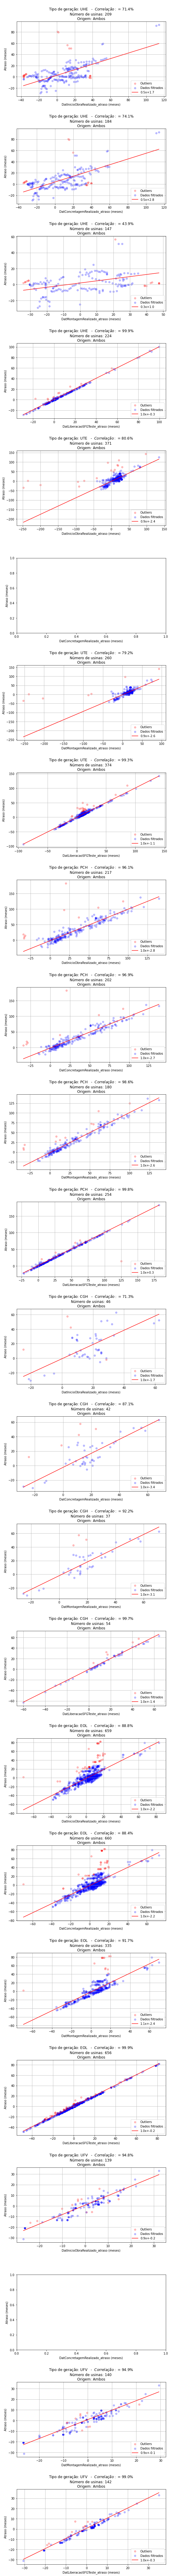

In [94]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]
tempo_construcao_nomes = {v: k for k, v in nomes_tempo_construcao.items()}

matrix_pearson = {}
matrix_pearson_out = {}

def calc_regression():
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res
    
    return [a, b, r, p_value, std_err]
    
def start_axes():
    ax = axes[count]
    ax.set_xlabel(f"{nome_coluna} (meses)")
    ax.set_ylabel(f"Atraso (meses)")
    return ax


for k,origem in enumerate(analises_origem):
    
    if not plot_created:    
        num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
        fig, axes = plt.subplots(num_subplots,len(analises_origem),figsize=(len(analises_origem)*8,num_subplots*5))
        plot_created =True
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        for nome_coluna in nomes_colunas_atrasos:
            count+=1
            try:
                ax = start_axes()
                
                # Calcula outliers
                idx_notna = (atraso_usina[nome_coluna].notna()) & (atraso_usina.SigTipoGeracao == SigTipoGeracao) 
                atraso_usin
                ordered_notna = atraso_usina[idx_notna].sort_values(by = nome_coluna)
                x = ordered_notna[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                x_plot = np.linspace(x.min(),x.max(),100)
                th = 1.65
                outliers = ((tempo_construcao_por_usina_norm[tempo_construcao_nomes[nome_coluna[:-7]]]) > th)| ((tempo_construcao_por_usina_norm[tempo_construcao_nomes[nome_coluna[:-7]]]) < -th)
                
                # Plota outliers
                ordered_notna_out = atraso_usina[ idx_notna & outliers ].sort_values(by = nome_coluna)
    
                x = ordered_notna_out[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna_out["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                
                ax.scatter(x,y,color="red",alpha=0.25,label="Outliers")
                
                
                ordered_notna_not_out = atraso_usina[ idx_notna & ~outliers ].sort_values(by = nome_coluna)
                x = ordered_notna_not_out[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna_not_out["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                ax.scatter(x,y,color="blue",alpha=0.25,label="Dados filtrados")
                a, b, r, p_value, std_err = calc_regression()
                r_str = f"{100*r:.1f}%"
                matrix_pearson[SigTipoGeracao].append(r_str)
                ax.plot(x_plot,a*x_plot+b+1,color="red",label= f"{a:.1f}x+{b:.1f}")
                ax.set_title(f"\nTipo de geração: {SigTipoGeracao}   -  $Correlação:$ = {r_str}\nNúmero de usinas: {x.shape[0]} \nOrigem: {origem}")
                ax.legend(loc="lower right")
                ax.grid()
                
               
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}")
                matrix_pearson[SigTipoGeracao].append("-")
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)

In [97]:
stats.norm(0.5)

In [77]:
x.max()

35.1

In [85]:
np.linspace()

array([-30.6, -30.1, -29.6, -29.1, -28.6, -28.1, -27.6, -27.1, -26.6,
       -26.1, -25.6, -25.1, -24.6, -24.1, -23.6, -23.1, -22.6, -22.1,
       -21.6, -21.1, -20.6, -20.1, -19.6, -19.1, -18.6, -18.1, -17.6,
       -17.1, -16.6, -16.1, -15.6, -15.1, -14.6, -14.1, -13.6, -13.1,
       -12.6, -12.1, -11.6, -11.1, -10.6, -10.1,  -9.6,  -9.1,  -8.6,
        -8.1,  -7.6,  -7.1,  -6.6,  -6.1,  -5.6,  -5.1,  -4.6,  -4.1,
        -3.6,  -3.1,  -2.6,  -2.1,  -1.6,  -1.1,  -0.6,  -0.1,   0.4,
         0.9,   1.4,   1.9,   2.4,   2.9,   3.4,   3.9,   4.4,   4.9,
         5.4,   5.9,   6.4,   6.9,   7.4,   7.9,   8.4,   8.9,   9.4,
         9.9,  10.4,  10.9,  11.4,  11.9,  12.4,  12.9,  13.4,  13.9,
        14.4,  14.9,  15.4,  15.9,  16.4,  16.9,  17.4,  17.9,  18.4,
        18.9,  19.4,  19.9,  20.4,  20.9,  21.4,  21.9,  22.4,  22.9,
        23.4,  23.9,  24.4,  24.9,  25.4,  25.9,  26.4,  26.9,  27.4,
        27.9,  28.4,  28.9,  29.4,  29.9,  30.4,  30.9,  31.4,  31.9,
        32.4,  32.9,

In [31]:
tempo_construcao_por_usina_norm[outliers]

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
83,27044,CGH,1.205172,1.37883,NaT,3.956244,0.732387
140,27968_1,UHE,-0.204445,NaT,NaT,9.253417,-0.259726
200,28374,UTE,3.462131,NaT,NaT,4.389158,4.262759
336,28840,PCH,NaT,NaT,NaT,-14.973047,-0.555013
359,28916,UTE,1.706753,NaT,NaT,7.612574,1.69997
722,29736_14,UHE,0.495972,0.82362,0.819574,4.626909,0.985147
776,29999,UTE,0.158197,NaT,NaT,4.440323,0.862383
793,30040,UTE,1.444951,NaT,1.259243,4.983955,1.439832
796,30043,UTE,0.975018,NaT,NaT,6.032844,0.946713


In [37]:
atraso_usina[(atraso_usina[nome_coluna].notna())
                                                 & (atraso_usina.SigTipoGeracao == SigTipoGeracao) & (outliers) ].sort_values(by = nome_coluna)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
3957,37585,UFV,220 days,37 days 21:46:29.403973508,NaT,-7 days +08:09:36,-167 days +22:24:38.145695364
